## Initialization

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))
DATA_DIR = os.path.join(CURRENT_DIR, 'data')

TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test')

In [3]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

## Read and clean the data

In [4]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

def deduplicate(train_data, test_data):
    train_data['is_test'] = 0
    test_data['is_test'] = 1

    data = pd.concat([train_data, test_data])
    # For some reason concatenation converts this column to object
    data['native_country'] = data.native_country.astype('category')
    data = data.drop_duplicates()
    
    train_data = data[data.is_test == 0].drop('is_test', axis=1)
    test_data = data[data.is_test == 1].drop('is_test', axis=1)
    
    return train_data, test_data

train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

# Note that we did de-duplication per dataset, but there are duplicates
# between training and test data. With duplicates between datasets
# we will might get overconfident results.
train_data, test_data = deduplicate(train_data, test_data)
print("Percent of the positive classes in the training data: {:.2%}".format(np.mean(train_data.income_class)))

Percent of the positive classes in the training data: 24.78%


In [5]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,Cuba,0


## Plot functions

In [6]:
def check_feature_importance(linear_classifier, feature_names):
    xs = np.arange(len(feature_names))
    plt.title("Feature importances (for last fold)")
    plt.barh(xs, linear_classifier.coef_[0])
    plt.yticks(xs, feature_names)

In [7]:
def plot_precision_recall_curves(pr_curves):
    curves = []
    for precision, recall in pr_curves:
        curve, = plt.plot(recall, precision)
        curves.append(curve)
        
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.tight_layout()

In [8]:
def plot_f1_curves(f1_curves, thresholds):
    curves = []
    for f1_values in f1_curves:
        curve, = plt.plot(thresholds, f1_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('F1 values')
    plt.xlabel('Classification threshold')
    plt.tight_layout()

In [9]:
def plot_kappa_curves(kappa_curves, thresholds):
    curves = []
    for kappa_values in kappa_curves:
        curve, = plt.plot(thresholds, kappa_values)
        curves.append(curve)

    plt.legend(curves, ['Fold #{}'.format(i) for i in range(1, len(curves) + 1)])
    plt.ylabel('Kappa values')
    plt.xlabel('Classification threshold')
    plt.tight_layout()

In [10]:
# Code from: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/separation_plot.py
# Code was reformated in order to fit better into general code style
def separation_plot( p, y, **kwargs ):
    """
    This function creates a separation plot for logistic and probit classification. 
    See http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf
    
    p: The proportions/probabilities, can be a nxM matrix which represents M models.
    y: the 0-1 response variables.
    
    """
    p = p.flatten()
    y = y.flatten()
    n = p.size

    colors_bmh = np.array(["#eeeeee", "#348abd"])
    ix = np.argsort(p)
    ax = plt.gca()

    # plot the different bars
    bars = ax.bar(
        np.arange(n),
        np.ones(n),
        width=1.,
        color=colors_bmh[y[ix].astype(int)], 
        edgecolor='none'
    )
    ax.plot(
        np.arange(n + 1),
        np.append(p[ix], p[ix][-1]),
        "k",
        linewidth=1.,
        drawstyle="steps-post"
    )

    # create expected value bar.
    ax.vlines([(1 - p[ix]).sum()], [0], [1])
    plt.xlim(0, n)
        
    plt.tight_layout()

## Model validator

In [11]:
from functools import partial
from collections import defaultdict

import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import metrics

def collect_metrics(fold_metrics, actual, predicted_proba, thresholds):
    kappa_score = partial(metrics.cohen_kappa_score, actual)
    
    fold_metrics['roc_scores'].append(metrics.roc_auc_score(actual, predicted_proba))
    fold_metrics['f1_scores'].append(metrics.f1_score(actual, predicted_proba.round()))
    fold_metrics['kappa'].append(kappa_score(predicted_proba.round()))
    fold_metrics['accuracy'].append(metrics.accuracy_score(actual, predicted_proba.round()))

    precision, recall, _ = metrics.precision_recall_curve(actual, predicted_proba)
    kappa_values = [kappa_score(predicted_proba > threshold) for threshold in thresholds]
    f1_values = [metrics.f1_score(actual,  predicted_proba > threshold) for threshold in thresholds]
    
    fold_metrics['pr_curves'].append((precision, recall))
    fold_metrics['kappa_curves'].append(kappa_values)
    fold_metrics['f1_curves'].append(f1_values)
    
def print_last_fold_stats(fold_metrics):
    print("ROC AUC score : {:.3f}".format(fold_metrics['roc_scores'][-1]))
    print("Kappa score   : {:.3f}".format(fold_metrics['kappa'][-1]))
    print("F1 score      : {:.3f}".format(fold_metrics['f1_scores'][-1]))
    print("Accuracy      : {:.3f}".format(fold_metrics['accuracy'][-1]))

def validate_model(model, X, y):
    kfold = KFold(n_splits=4, shuffle=True)
    fold_metrics= defaultdict(list)
    thresholds = np.arange(0.1, 1, 0.1)
    
    for i, (train_index, valid_index) in enumerate(kfold.split(X), start=1):
        x_train, x_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if isinstance(model, lgb.LGBMClassifier):
            # From the LGB we can get plot that shows progress
            # for training and validation data.
            # We don't show it, but information can be available
            # from the model.
            model.fit(
                x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                verbose=False,
            )
        else:
            model.fit(x_train, y_train)

        x_predicted_probas = model.predict_proba(x_valid)
        x_predicted_proba = x_predicted_probas[:, 1]

        collect_metrics(fold_metrics, y_valid, x_predicted_proba, thresholds)
        
        print("Fold #{}".format(i))
        print_last_fold_stats(fold_metrics)
        print('-' * 30)
        
    print("")
    print("Average ROC AUC across folds  : {:.3f}".format(np.mean(fold_metrics['roc_scores'])))
    print("Average Kappa across folds    : {:.3f}".format(np.mean(fold_metrics['kappa'])))
    print("Average F1 across folds       : {:.3f}".format(np.mean(fold_metrics['f1_scores'])))
    print("Average accuracy across folds : {:.3f}".format(np.mean(fold_metrics['accuracy'])))
    
    plt.figure(figsize=(14, 8))
    
    plt.subplot(221)
    plt.title("Separation plot for last fold")
    separation_plot(x_predicted_proba, y_valid)
    
    plt.subplot(222)
    plt.title("Precision-recall curves")
    plot_precision_recall_curves(fold_metrics['pr_curves'])
    
    plt.subplot(223)
    plt.title("Kappa values for different thresholds")
    plot_kappa_curves(fold_metrics['kappa_curves'], thresholds)
    
    plt.subplot(224)
    plt.title("F1 values for different thresholds")
    plot_f1_curves(fold_metrics['f1_curves'], thresholds)

    plt.show()

## Linear model

The first model prototype will be build using logistic regression. This algorithm easier to debug and anylise. In addition, it provides good banchmark for future imrovements.

### with only 3 numerical features

It's easier to start with numerical features first, since they don't require extra transformations.

Fold #1
ROC AUC score : 0.783
Kappa score   : 0.273
F1 score      : 0.392
Accuracy      : 0.779
------------------------------
Fold #2
ROC AUC score : 0.793
Kappa score   : 0.306
F1 score      : 0.422
Accuracy      : 0.784
------------------------------
Fold #3
ROC AUC score : 0.798
Kappa score   : 0.327
F1 score      : 0.443
Accuracy      : 0.787
------------------------------
Fold #4
ROC AUC score : 0.786
Kappa score   : 0.291
F1 score      : 0.410
Accuracy      : 0.777
------------------------------

Average ROC AUC across folds  : 0.790
Average Kappa across folds    : 0.299
Average F1 across folds       : 0.417
Average accuracy across folds : 0.782


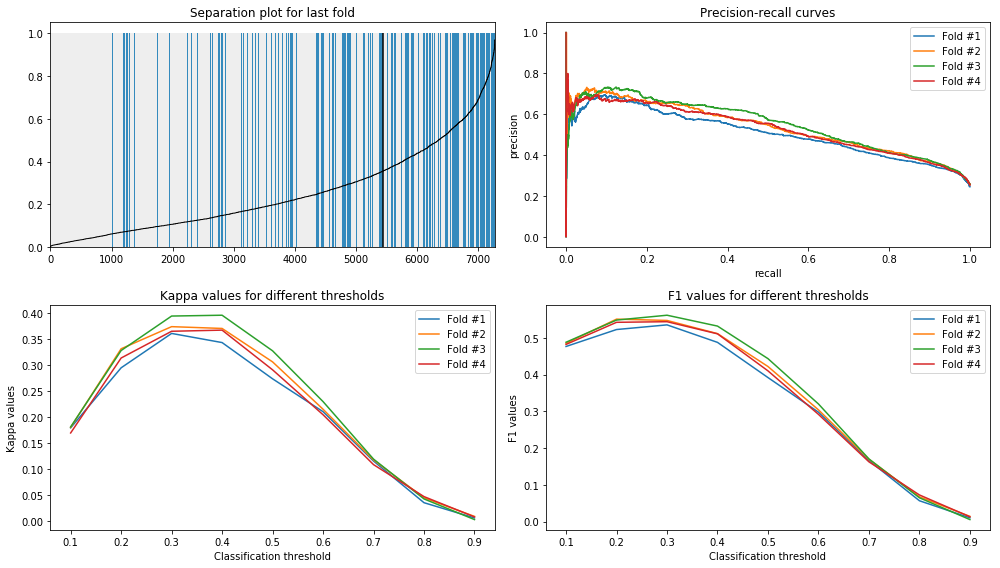

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

features = [
    'age',
    'education_num',
    'hours_per_week',
]

X = train_data[features].values.astype(float)
y = train_data[target_column].values

model = Pipeline([
    # Scaling allows us to normalize variables. It will
    # make models coeficients interpratable.
    ('normalizer', StandardScaler()),
    ('classifier', LogisticRegression()),
])
validate_model(model, X, y)

Only 3 numerical columns give prediction with ROC AUC score almost equal to 0.8, which is a good start. On the other hand kappa and f1 scores are low. These score depend on the 0.5 threshold (unlike ROC AUC score) and it's just a bad choice for class separation. From the two lower plots we can see that F1 and Kappa scores can be improved if we pick threshold equal to 0.3.

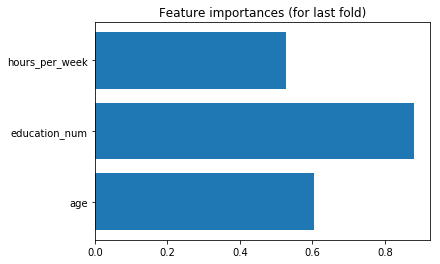

In [13]:
check_feature_importance(
    linear_classifier=model.named_steps['classifier'],
    feature_names=features,
)

As previous analysis showed, numerical features have low correlation between each other, and because we normalized all the features to single scale we can use coeficients from the logistic regression in order to interpret classification decisions.

It looks like number of education years (`education_num` column) provides largest impact into the final prediction. One extra year of the education will have larger impact on the models outcome compare to one extra year added to the age.

### With all 5 numerical features

We can add two more numerical columns, namely `capital_gain` and `capital_loss`.

Fold #1
ROC AUC score : 0.824
Kappa score   : 0.402
F1 score      : 0.509
Accuracy      : 0.809
------------------------------
Fold #2
ROC AUC score : 0.821
Kappa score   : 0.398
F1 score      : 0.507
Accuracy      : 0.808
------------------------------
Fold #3
ROC AUC score : 0.824
Kappa score   : 0.399
F1 score      : 0.503
Accuracy      : 0.813
------------------------------
Fold #4
ROC AUC score : 0.829
Kappa score   : 0.405
F1 score      : 0.513
Accuracy      : 0.808
------------------------------

Average ROC AUC across folds  : 0.825
Average Kappa across folds    : 0.401
Average F1 across folds       : 0.508
Average accuracy across folds : 0.810


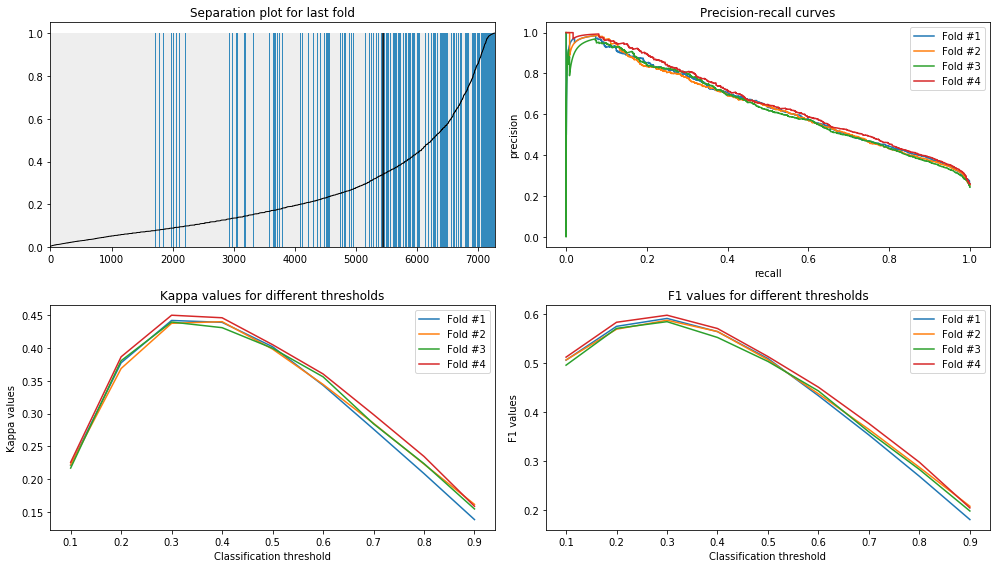

In [14]:
features = [
    'age',
    'education_num',
    'hours_per_week',
    'capital_gain',
    'capital_loss',
]

# The capital_gain column has NaN values. Because most of the
# values in this column has no income gain it will be safe to
# assume that missing values are also equal to zero
X = train_data[features].fillna(0).values.astype(float)
y = train_data[target_column].values

validate_model(model, X, y)

We got large improvement in kappa and f1 scores (by rougly 0.1) and noticable, but relatively small increase in ROC AUC score (from 0.79 to 0.825). In addition from the separation plot you can notice that there are a lot of the blue regions on the right side of the plot which means that network is more confident in prediction for some of the positive classes. 

The left part of the separation plot have reduced number of false negative cases (type 2 error).

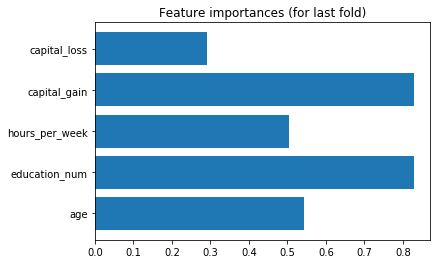

In [15]:
check_feature_importance(
    linear_classifier=model.named_steps['classifier'],
    feature_names=features,
)

It makes sence that the `capital_gain` variable has large feature importance, since extra income adds up to the total income and therefor increases probability that total income > $50K/year. It might be a bit strange that we added on of the most important features so far, but ROC AUC score didn't increase that much. The reason for it is that we have low number of classes that have non zero `capital_gain`.

### Adding categorical features to the model

In ordert to use categorical features we need to transform them into binary variables (one hot encoder).

In [16]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

def features_with_one_hot_encoded_categories(data, cat_columns=None, fillna=True):
    cat_data = get_categorical_columns(data, cat_columns, fillna)
    one_hot_data = pd.get_dummies(cat_data)
    df = pd.concat([data, one_hot_data], axis=1)

    features = [
        'age',
        'education_num',
        'hours_per_week',
        'capital_gain',
        'capital_loss',
    ] + one_hot_data.columns.tolist()

    X = df[features].fillna(0).values.astype(float)
    y = df[target_column].values
    
    return X, y

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold #1
ROC AUC score : 0.899
Kappa score   : 0.546
F1 score      : 0.649
Accuracy      : 0.840
------------------------------
Fold #2
ROC AUC score : 0.902
Kappa score   : 0.563
F1 score      : 0.660
Accuracy      : 0.848
------------------------------
Fold #3
ROC AUC score : 0.900
Kappa score   : 0.558
F1 score      : 0.658
Accuracy      : 0.845
------------------------------
Fold #4
ROC AUC score : 0.901
Kappa score   : 0.550
F1 score      : 0.652
Accuracy      : 0.841
------------------------------

Average ROC AUC across folds  : 0.900
Average Kappa across folds    : 0.554
Average F1 across folds       : 0.654
Average accuracy across folds : 0.843


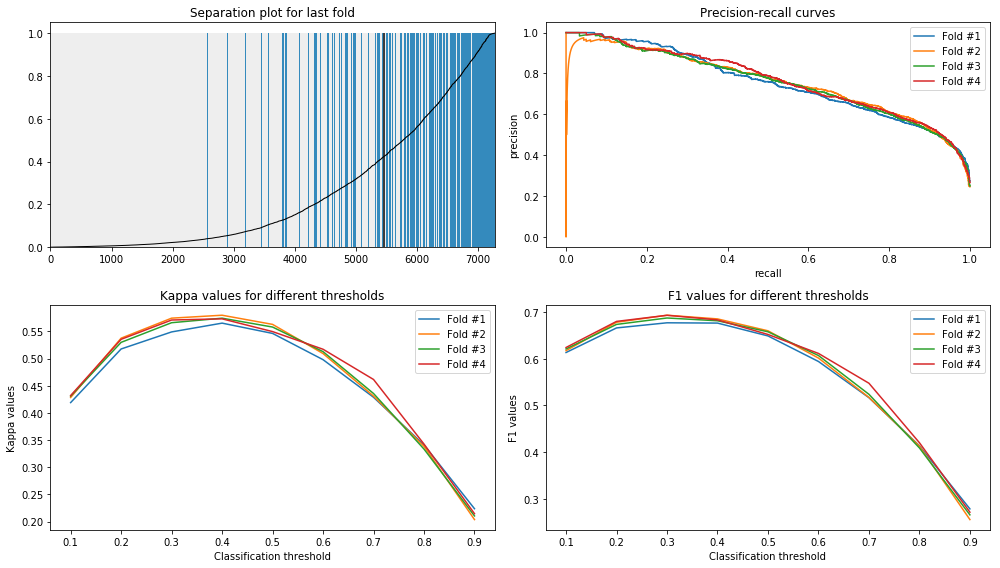

In [17]:
X, y = features_with_one_hot_encoded_categories(train_data)
validate_model(model, X, y)

When we added categorical features we got another large improvement in every metric. Now average score between different folds jumped to 0.9. The F1 and Kappa scores were also improved by 0.15.

From the separation plot we can see that positive classes are now form dense regions.

Also, The threshold plots don't have noticable spike near 0.3 anymore. Instead it has concave shape, which means that the difference between 0.3-0.4 now less noticably and class probabilities are getting separated better.

## Decision Tree

Linear models are often not the best choice since they are not able to capture full complexity of the data. Decision tree is another simple algorithm that can capture non-linear properties from the data.

### One hot encoded features

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold #1
ROC AUC score : 0.900
Kappa score   : 0.559
F1 score      : 0.654
Accuracy      : 0.848
------------------------------
Fold #2
ROC AUC score : 0.899
Kappa score   : 0.558
F1 score      : 0.658
Accuracy      : 0.844
------------------------------
Fold #3
ROC AUC score : 0.902
Kappa score   : 0.562
F1 score      : 0.659
Accuracy      : 0.846
------------------------------
Fold #4
ROC AUC score : 0.900
Kappa score   : 0.552
F1 score      : 0.647
Accuracy      : 0.848
------------------------------

Average ROC AUC across folds  : 0.900
Average Kappa across folds    : 0.557
Average F1 across folds       : 0.655
Average accuracy across folds : 0.846


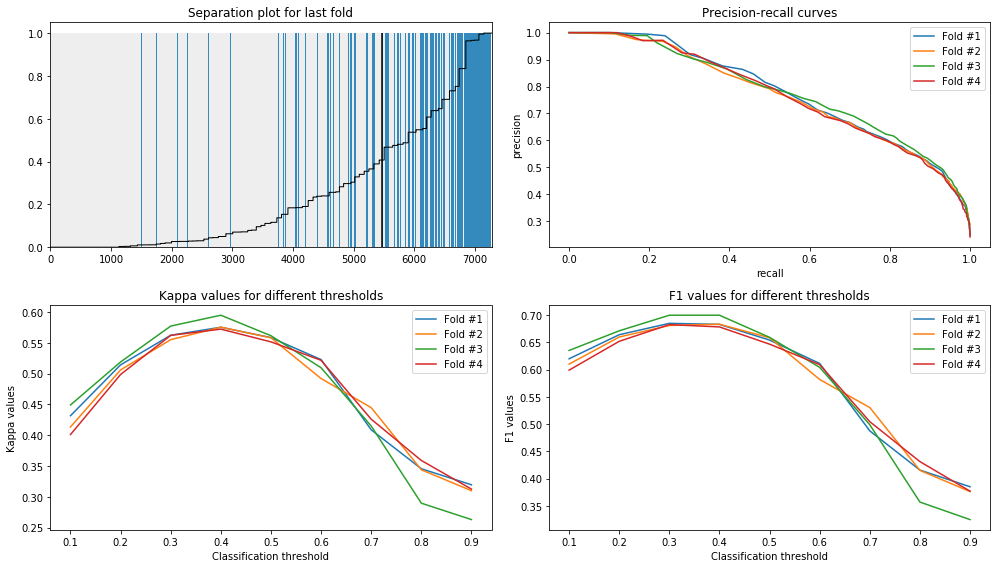

In [18]:
from sklearn.tree import DecisionTreeClassifier

X, y = features_with_one_hot_encoded_categories(train_data)
model = DecisionTreeClassifier(
    min_samples_leaf=200,
    criterion='entropy',
)
validate_model(model, X, y)

From the plot we can see that there is almost now difference between scores compare to the linear model

### Categories labeled with integers

With decision trees we can try to reduce number of features. Instead of using one hot encoded features we can use each categorical column with categorical values replaced by integer values.

In [19]:
def features_with_labeled_categories(data, cat_columns=None, fillna=True):
    cat_data = get_categorical_columns(data, cat_columns, fillna)
    cat_labeled_data = cat_data.apply(lambda x: x.cat.codes)
    
    numerical_features = [
        'age',
        'education_num',
        'hours_per_week',
        'capital_gain',
        'capital_loss',
    ]
    numerical_data = data[numerical_features]
    
    if fillna:
        numerical_data = numerical_data.fillna(0)
    
    X = np.concatenate([
        numerical_data.values.astype(float),
        cat_labeled_data.values,
    ], axis=1)
    y = data[target_column].values

    feature_names = numerical_features + cat_data.columns.tolist()
    return X, y, feature_names

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold #1
ROC AUC score : 0.898
Kappa score   : 0.531
F1 score      : 0.633
Accuracy      : 0.838
------------------------------
Fold #2
ROC AUC score : 0.884
Kappa score   : 0.526
F1 score      : 0.632
Accuracy      : 0.835
------------------------------
Fold #3
ROC AUC score : 0.904
Kappa score   : 0.564
F1 score      : 0.656
Accuracy      : 0.852
------------------------------
Fold #4
ROC AUC score : 0.901
Kappa score   : 0.544
F1 score      : 0.638
Accuracy      : 0.847
------------------------------

Average ROC AUC across folds  : 0.897
Average Kappa across folds    : 0.541
Average F1 across folds       : 0.639
Average accuracy across folds : 0.843


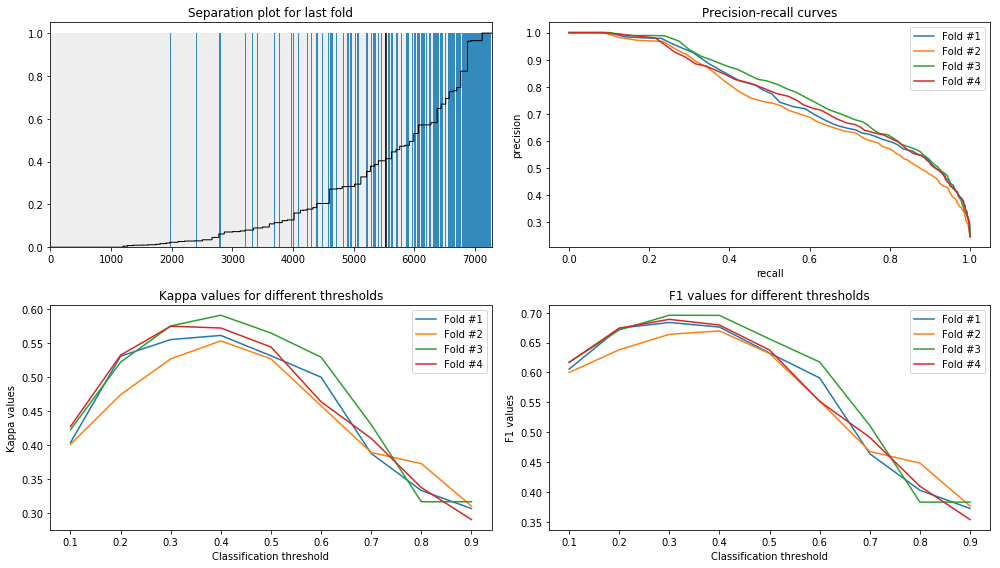

In [20]:
from sklearn.tree import DecisionTreeClassifier

X, y, feature_names = features_with_labeled_categories(train_data)
model = DecisionTreeClassifier(
    min_samples_leaf=200,
    criterion='entropy',
)
validate_model(model, X, y)

Even though score didn't change we still imroved our model by reducing number of features by one order of magnitude (from 100+ to 10+)

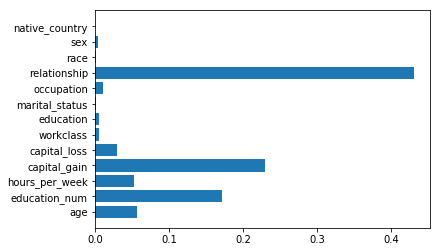

In [21]:
xs = np.arange(len(feature_names))
plt.barh(xs, model.feature_importances_)
plt.yticks(xs, feature_names);

It's interesting that importance for the numerical feature is quite similar to the one that we get from the linear model. Also, it's not surprising that features like `race`, `native_country` are not importance, since logically they shouldn't have any impact. The `education` column probably correlated with `education_num` and it's importance could be reduced.

It's a bit surprising that `occupation` and `martial_status` features have such a low impact on the final prediction. It looks like we need to change our model to something better.

## Gradient Boosted Trees

Gradient boosted trees is just a good choice for the tree ensembling methods.

### Labeled catgorical features

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold #1
ROC AUC score : 0.924
Kappa score   : 0.625
F1 score      : 0.713
Accuracy      : 0.865
------------------------------
Fold #2
ROC AUC score : 0.923
Kappa score   : 0.632
F1 score      : 0.717
Accuracy      : 0.869
------------------------------
Fold #3
ROC AUC score : 0.927
Kappa score   : 0.624
F1 score      : 0.710
Accuracy      : 0.867
------------------------------
Fold #4
ROC AUC score : 0.922
Kappa score   : 0.618
F1 score      : 0.702
Accuracy      : 0.866
------------------------------

Average ROC AUC across folds  : 0.924
Average Kappa across folds    : 0.625
Average F1 across folds       : 0.711
Average accuracy across folds : 0.867


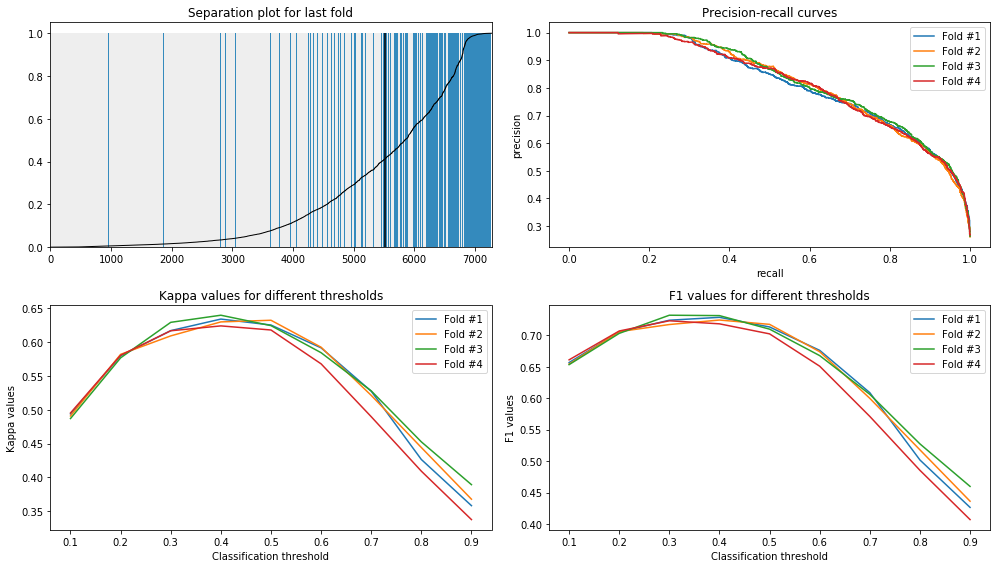

In [22]:
X, y, feature_names = features_with_labeled_categories(train_data)
# Looks like default values give good enough result improvements
model = lgb.LGBMClassifier()
validate_model(model, X, y)

With default configuration GBT managed to improve scores that we got from the decision tree and linear model. The graph on the separation plot changed it's shape showing that model can prediction positive classes with higher confidence and precision-recall curve shows the improved quality of the predictions compare to the previous methods

In [23]:
model.evals_result_.keys()

dict_keys(['valid_0', 'valid_1'])

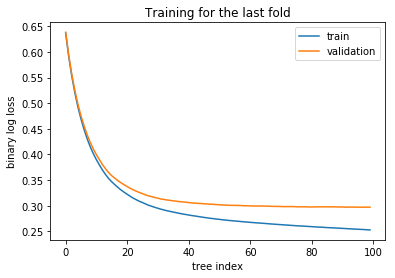

In [24]:
plt.title("Training for the last fold")
train_curve, = plt.plot(model.evals_result_['valid_0']['binary_logloss'])
test_curve, = plt.plot(model.evals_result_['valid_1']['binary_logloss'])

plt.ylabel('binary log loss')
plt.xlabel('tree index')
plt.legend([train_curve, test_curve], ['train', 'validation']);

It looks like we didn't overfit during the training

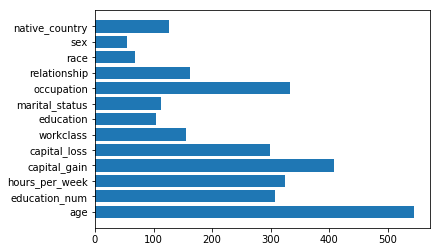

In [25]:
xs = np.arange(len(feature_names))
plt.barh(xs, model.feature_importances_)
plt.yticks(xs, feature_names);

It does look a bit surprising how certaing featres suddenly get importance. The split method for feature importance is not very reliable and it makes sence to see their importance using SHAP algorithm.

### One hot encoded categorical features

/Users/itdxer/.pyenv/versions/3.6.0/envs/neupy36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fold #1
ROC AUC score : 0.927
Kappa score   : 0.624
F1 score      : 0.712
Accuracy      : 0.865
------------------------------
Fold #2
ROC AUC score : 0.926
Kappa score   : 0.614
F1 score      : 0.701
Accuracy      : 0.865
------------------------------
Fold #3
ROC AUC score : 0.924
Kappa score   : 0.631
F1 score      : 0.714
Accuracy      : 0.870
------------------------------
Fold #4
ROC AUC score : 0.922
Kappa score   : 0.613
F1 score      : 0.701
Accuracy      : 0.863
------------------------------

Average ROC AUC across folds  : 0.925
Average Kappa across folds    : 0.620
Average F1 across folds       : 0.707
Average accuracy across folds : 0.866


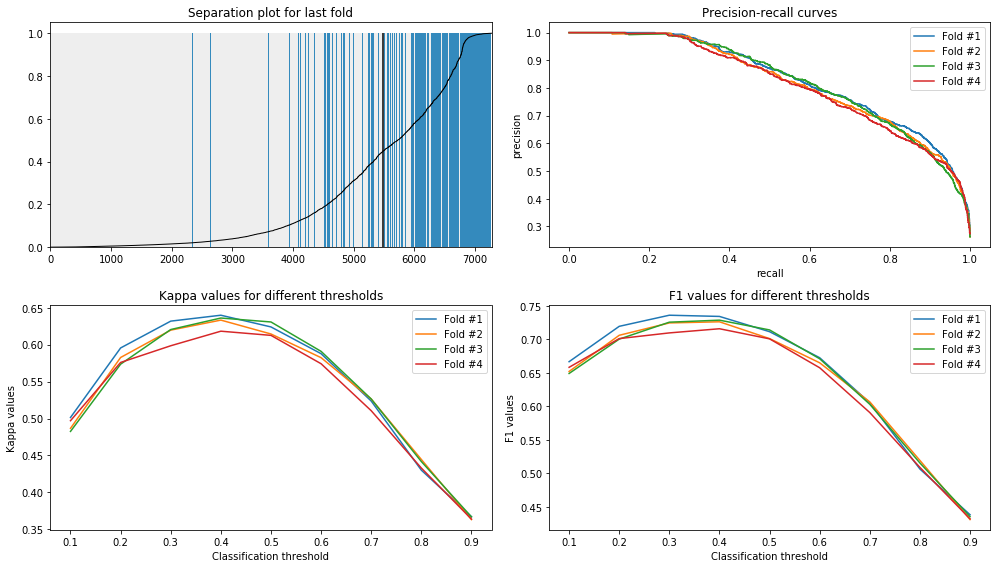

In [26]:
X, y = features_with_one_hot_encoded_categories(train_data)
# Looks like default values give good enough result improvements
model = lgb.LGBMClassifier()
validate_model(model, X, y)

It doesn't look like one-hot encoded categorical features make a difference. They just increase training time and it's better to avoid them.

## Evaluating test dataset

In [27]:
n_train_samples = len(train_data)
fold_metrics = defaultdict(list)

# In every model probability threshold 0.3 and 0.4 showed best results
# For this reason we will use one threshold equal to 0.35
thresholds = np.array([0.35])

data = pd.concat([train_data, test_data], ignore_index=True)
X, y, feature_names = features_with_labeled_categories(data, fillna=False)

X_train, y_train = X[:n_train_samples], y[:n_train_samples]
X_test, y_test = X[n_train_samples:], y[n_train_samples:]

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_predicted_probas = model.predict_proba(X_test)
y_predicted_proba = y_predicted_probas[:, 1]

collect_metrics(fold_metrics, y_test, y_predicted_proba, thresholds)
print_last_fold_stats(fold_metrics)

ROC AUC score : 0.926
Kappa score   : 0.627
F1 score      : 0.709
Accuracy      : 0.871


Prediction accuracy on the test set very close to the one that we got from the average cross validation which means that previous design based on the training data is correct.

## Analyze models decisions

In [28]:
import shap
shap.initjs()

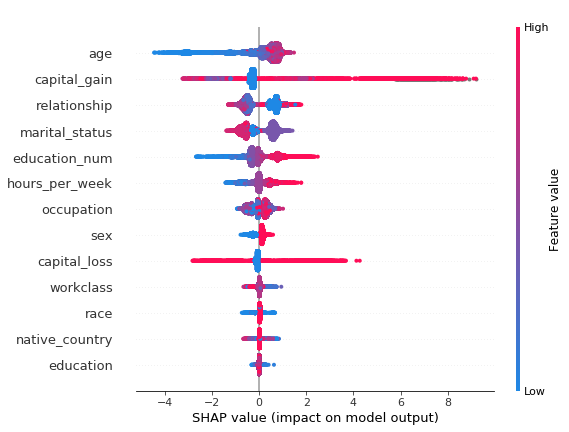

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, feature_names)

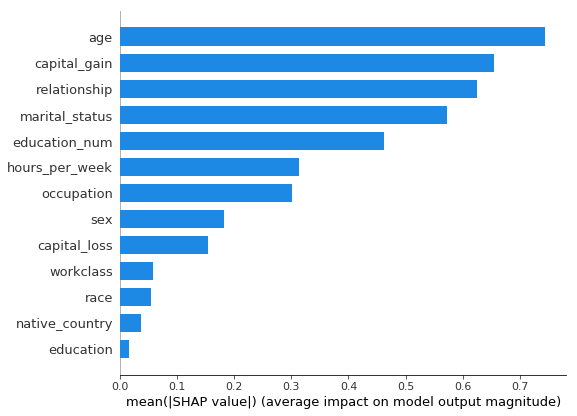

In [31]:
shap.summary_plot(shap_values, X, feature_names, plot_type='bar')

Observations:

1. The `education` column mostly duplicates information obtained from the `education_num` column, that's probably why it has low impact.

2. Native country contains mostly US and other countries probably don't have large impact on the outcome.

3. Race also looks like a strange variable to use for outcome prediction.

## Gradient Boosted Trees with small updates

In [32]:
X_modified = pd.DataFrame(X, columns=feature_names)
X_modified = X_modified[[
    'age', 'education_num',
    'hours_per_week',
    'capital_gain', 'capital_loss',
    'marital_status', 'occupation',
    'relationship', 'sex',
]].values

Fold #1
ROC AUC score : 0.927
Kappa score   : 0.621
F1 score      : 0.705
Accuracy      : 0.868
------------------------------
Fold #2
ROC AUC score : 0.927
Kappa score   : 0.615
F1 score      : 0.702
Accuracy      : 0.865
------------------------------
Fold #3
ROC AUC score : 0.927
Kappa score   : 0.631
F1 score      : 0.714
Accuracy      : 0.870
------------------------------
Fold #4
ROC AUC score : 0.927
Kappa score   : 0.630
F1 score      : 0.711
Accuracy      : 0.871
------------------------------

Average ROC AUC across folds  : 0.927
Average Kappa across folds    : 0.624
Average F1 across folds       : 0.708
Average accuracy across folds : 0.869


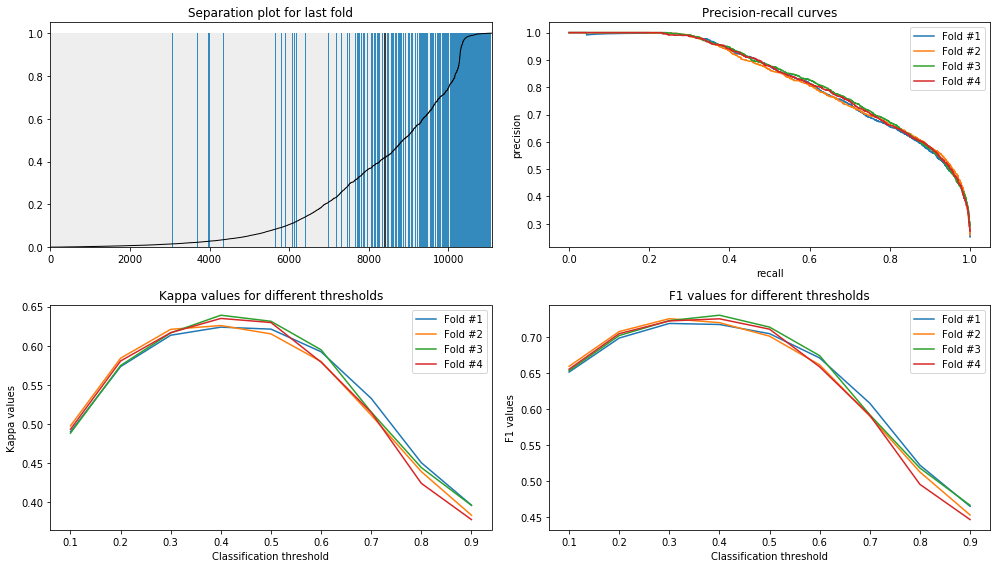

In [33]:
# Looks like default values give good enough result improvements
model = lgb.LGBMClassifier()
validate_model(model, X_modified, y)

Removing feautres with low shaply values showed almost now difference in the prediction for the metric scores. It also shows how unreliable can be feature importances provided by default methods.

## Conclusions

There wasn't a lot of surpirsing findings during the analysis of the data and models decisions that can be seen using shapley values are intiutive which ensure stranges of the decisions made by the model. With quite simple preprocessing and default configurations for Gradient Boosted Trees it was possible to achive high ROC AUC score on the test data: ~0.925.

## What else can be done?

1. Final GBT model uses default configurations and it wasn't tuned. Some improvement can be done by tuning it

2. Spend more time analysing mistakes that has been made my the algorithm per each example. For example, we can check samples that have largest errors and see why model made these mistakes (using shaply values)

3. Experiment with different approaches for classification threshold selection and classifier calibration.

4. Try to prune small categories and combine them into common category

5. Feature engineering

6. Analyze effect that each separate value from the each category have on the final score (using SHAP)
